# How to bring the DLR files to the format of KNMI ?

* I asked Lok from DLR if there is a possibility to have the fields on 2D instead of 1D: 

> <html> Hi Bijan,

> Thanks for your comments!

> We understand that it is easier to handle if the data is in 2D array. The file size will also be smaller too.

> The current file format is a heritage from the GOME2 data processor, it will take us some time to change it to the 2D format, but we are working on it. I guess it can be done in the next release. I hope that wont be a big problem for you to use the current version of data.

> Thanks and have a nice day!

> Lok

<p>

>  On 07/15/2019 11:58 AM, bijan.fallah wrote:

>    Hello Lok,

>    it was nice to see you at the meeting in Freiburg. I had a question regarding the TROPOMI data from DLR.    KNMI is storing variables in such a format : like nitrogendioxide_tropospheric_column(time=1,scanline=~3246,ground_pixel=450) where DLR is storing like : VCDTropo(fakeDim0).

>    My question is it possible to convert the fakeDim0 into scanline x ground_pixel as in KNMI?

>    This will help me a lot in rewriting my code.

>    Cheers,
>    Bijan) 
> </html>
<p>



In [86]:
# load all the stuff here:
import logging
import os 
import netCDF4
import numpy
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
from matplotlib.gridspec import GridSpec
import pyprind as prog
import psutil
import multiprocessing
import time

In [2]:
# two sample files from DLR and KNMI
#dir_emip="/home/fallah/Documents/Martijn/CODES/EMPI_TROPOMI/EMIP_02_DLR/vtrunk"
sf_dlr="DLR/S5P_OFFL_L2__NO2____20180722T093242_20180722T111411_04001_01_010100_20180728T111950.nc"
sf_knmi="KNMI/S5P_OFFL_L2__NO2____20180722T093242_20180722T111411_04001_01_010100_20180728T111950.nc"

In [3]:
# first look into KNMI 
ncid_knmi = netCDF4.Dataset( sf_knmi, 'r' )
group = 'PRODUCT'
gid_knmi = ncid_knmi.groups[group]
print(gid_knmi)

<class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(sizes): scanline(3246), ground_pixel(450), corner(4), time(1), polynomial_exponents(6), intensity_offset_polynomial_exponents(1), layer(34), vertices(2)
    variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), int32 polynomial_exponents(polynomial_exponents), int32 intensity_offset_polynomial_exponents(intensity_offset_polynomial_exponents), int32 layer(layer), int32 vertices(vertices), float32 latitude(time,scanline,ground_pixel), float32 longitude(time,scanline,ground_pixel), int32 delta_time(time,scanline), <class 'str'> time_utc(time,scanline), uint8 qa_value(time,scanline,ground_pixel), float32 nitrogendioxide_tropospheric_column(time,scanline,ground_pixel), float32 nitrogendioxide_tropospheric_column_precision(time,scanline,ground_pixel), float32 nitrogendioxide_tropospheric_column_precision_kernel(time,scanline,ground_pixel), float32 averaging_ker

- You see that the variables are in 2D as time size is only 1, i.e. 
nitrogendioxide_tropospheric_column(time,scanline,ground_pixel)
and size of ground_pixel  is :



In [4]:
len(gid_knmi.dimensions['ground_pixel'])


450

- and size of scanline = 3246 and size of layer = 34

- now size of VCDTropo(fakeDim0) from DLR is 279695 and the layer = 18! 
  What we do not know is the size of scanline and the ground pixel

In [5]:
ncid_dlr = netCDF4.Dataset( sf_dlr, 'r' )
print(ncid_dlr)
len(ncid_dlr['VCDTropo'][:])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): fakeDim0(279695), fakeDim40(18)
    variables(dimensions): int32 QA(fakeDim0), float32 Time(fakeDim0), float32 LatitudeA(fakeDim0), float32 LatitudeB(fakeDim0), float32 LatitudeC(fakeDim0), float32 LatitudeD(fakeDim0), float32 LatitudeCentre(fakeDim0), float32 LongitudeA(fakeDim0), float32 LongitudeB(fakeDim0), float32 LongitudeC(fakeDim0), float32 LongitudeD(fakeDim0), float32 LongitudeCentre(fakeDim0), float32 SolarZenithAngleCentre(fakeDim0), float32 LineOfSightZenithAngleCentre(fakeDim0), float32 RelativeAzimuthCentre(fakeDim0), float32 SCD(fakeDim0), float32 SCD_Error(fakeDim0), float32 AMFStrato(fakeDim0), float32 AMFStrato_Error(fakeDim0), float32 AMFStratoToGround(fakeDim0), float32 AMFStratoToCloudTop(fakeDim0), float32 AMFTropo(fakeDim0), float32 AMFTropo_Error(fakeDim0), float32 AMFTropoToGround(fakeDim0), float32 AMFTropoToCloudTop(fakeDim0), uint8 NO2TropCorrection_

279695

### Therefor I decide to bring it in KNMI pixel! 


In [6]:
def read_the_nc(filename, sat):
    '''
    INPUT:
    - sat = 'KNMI' if you read KNMI
    - sat = 'DLR'  if you read DLR
    OUTPUT:
    - xi  -> lon
    - yi  -> lat
    - NO2 -> vertical tropospheric NO2 column (molec/cm2)
    ##TODO: it is a test for NO2 then you do it for all variables of DLR!
    '''
    if sat == 'KNMI':
        f = netCDF4.Dataset( filename, 'r' )
        print("---KNMI is being processed!---")
        NO2 = f['PRODUCT']['nitrogendioxide_tropospheric_column'][:].squeeze()
        lon = f['PRODUCT']['longitude'][:].squeeze()
        lat = f['PRODUCT']['latitude'][:].squeeze()
        NO2 = NO2*6.02214*(10**19)
    elif sat == 'DLR':
        
        print("---DLR is being processed!---")
        f = netCDF4.Dataset( filename, 'r' )
        NO2 = f['VCDTropo'][:]
        #NO2 = f['VCDCorrected'].value
        lon = f['LongitudeCentre'][:]
        lat = f['LatitudeCentre'][:]
    print('FINISHED')    
    return lon, lat, NO2


In [36]:
# Now read the lon lat of the center of pixel and the no2 value
lon_knmi, lat_knmi, no2_knmi = read_the_nc(sf_knmi, sat='KNMI') # read the values for knmi! 

lon_dlr, lat_dlr, no2_dlr = read_the_nc(sf_dlr, sat='DLR') # read the values for knmi! 
print('-------------------------------')
print("shape of knmi lon, lat and no2:",lon_knmi.shape, lat_knmi.shape, no2_knmi.shape )
print('-------------------------------')
print("shape of dlr lon, lat and no2:",lon_dlr.shape, lat_dlr.shape, no2_dlr.shape )


---KNMI is being processed!---
FINISHED
---DLR is being processed!---
FINISHED
-------------------------------
shape of knmi lon, lat and no2: (3246, 450) (3246, 450) (3246, 450)
-------------------------------
shape of dlr lon, lat and no2: (279695,) (279695,) (279695,)


- Now I plot regions of each satellite swath, DLR vs KNMI: 

In [37]:
def plot_the_no2(lon, lat, NO2, vmin, vmax, sat="KNMI"):
    
    m = Basemap(projection='mill',resolution='l', lon_0 = 90)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    xi, yi = m(lon, lat)
    #xi = lon
    #yi = lat

    Zm = ma.masked_where(numpy.isnan(NO2),NO2)
    
    #cs = m.contour(xi, yi, NO2, vmin=vmin, vmax=vmax, cmap="jet")
    if sat=="DLR":
        cs =m.scatter(xi,yi,edgecolors='none',s=1,c=NO2,  vmin=vmin, vmax=vmax,  cmap="jet", alpha=1)
    else:
        cs = m.pcolormesh(xi, yi, Zm, vmin=vmin, vmax=vmax, cmap="jet")
            
    
    cbar1 = m.colorbar(cs, location="bottom")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


Text(0.5, 1.0, 'DLR')

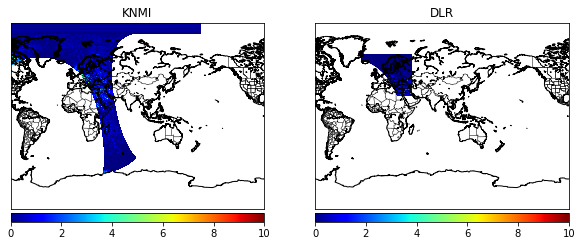

In [39]:
fig=plt.figure(figsize=(10, 6))
lon_dlr[lon_dlr>180]  = lon_dlr[lon_dlr>180]-360 # to bring DLR lon on -180 <lon_DLR <180 like KNMI!
gs=GridSpec(1,2) # 2 rows, 3 columns
ax1=fig.add_subplot(gs[0,0]) # First row, first column
plot_the_no2(lon_knmi, lat_knmi, no2_knmi/10**15, vmin=0, vmax=10,sat='KNMI')
ax1.set_title('KNMI')
ax2=fig.add_subplot(gs[0,1]) # First row, second column
plot_the_no2(lon_dlr, lat_dlr, no2_dlr/10**15, vmin=0, vmax=10,sat="DLR")
ax2.set_title('DLR')

- as it can be seen the DLR has a smaller domain compare to KNMI and be have to bring it on the same grid as KNMI!

> I frist reshape the knmi to have a 1D vector, then I find the position of the first pixel from dlr on knmi and
> fill the dlr_on_knmi vector!

In [121]:
# Reshaped KNMI:
no2_knmi_rshaped = no2_knmi.ravel()
lat_knmi_rshaped = lat_knmi.ravel()
lon_knmi_rshaped = lon_knmi.ravel()
# New DLR:
no2_dlr_new = numpy.ones(no2_knmi_rshaped.shape)*float('nan')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


(16928412.492241964, 25162952.916656293)

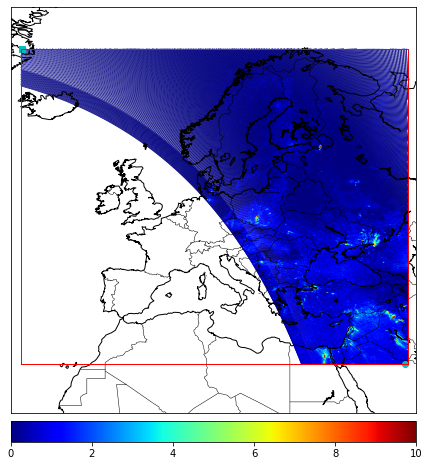

In [81]:
# A test plot to see if everything is okay
plt.figure(figsize=(10, 8))
plot_the_no2(lon_dlr, lat_dlr, no2_dlr/10**15, vmin=0, vmax=10,sat="DLR")
m = Basemap(projection='mill',resolution='l', lon_0 = 90)
x,y = m(lon_dlr[0],lat_dlr[0])
plt.plot(x-360, y,'co')
x,y = m(lon_dlr[-1],lat_dlr[-1])
plt.plot(x, y,'cs')
# plot box of dlr cut
px1,py1 = m(-24,28.5)
px2,py2 = m(-24,71)
plt.plot([px1,px2], [py1,py2], 'r-', lw=1, alpha=1)
px1,py1 = m(46.5,28.5)
px2,py2 = m(46.5,71)
plt.plot([px1,px2], [py1,py2], 'r-', lw=1, alpha=1)
px1,py1 = m(-24,28.5)
px2,py2 = m(46.5,28.5)
plt.plot([px1,px2], [py1,py2], 'r-', lw=1, alpha=1)
px1,py1 = m(-24,71)
px2,py2 = m(46.5,71)
plt.plot([px1,px2], [py1,py2], 'r-', lw=1, alpha=1)
x,y = m(lon_dlr[-1]-2,20)
x1,y1 = m(lon_dlr[0]+2,75)
plt.xlim([x,x1])
plt.ylim([y,y1])

In [122]:
# main core of program: 

lon_box_dlr = numpy.logical_and(lon_knmi_rshaped>=-24,lon_knmi_rshaped<=46.5)
lat_box_dlr = numpy.logical_and(lat_knmi_rshaped>=28.5 , lat_knmi_rshaped<=71)
msk_small_dlr = numpy.logical_and(lat_box_dlr,lon_box_dlr) # find the mask of dlr !


no2_dlr_new[msk_small_dlr] = no2_dlr
no2_dlr_new_rshaped_back =  []
no2_dlr_new_rshaped_back = no2_dlr_new.reshape(no2_knmi.shape)


0.0016903877258300781


In [ ]:

#pool = multiprocessing.Pool(4)
##no2_dlr_new_box_append = []
#def calc_regrid(index):
#    point_t = numpy.where(lon_knmi_rshaped_box == round_bij(lon_dlr[index]))[0][0]
#    no2_dlr_new_box[point_t] = no2_dlr[index]
#    
#t = time.time()
#zip(*pool.map(calc_regrid, range(len(lon_dlr))))
#elapsed = time.time() - t
#print(elapsed)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


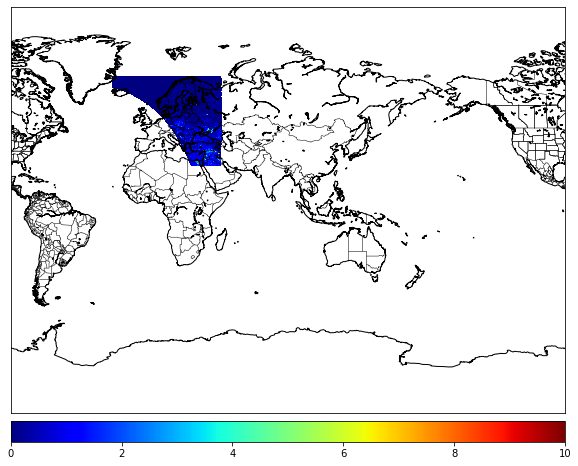

In [123]:
plt.figure(figsize=(10, 8))
plot_the_no2(lon_knmi, lat_knmi, no2_dlr_new_rshaped_back/10**15, vmin=0, vmax=10,sat='KNMI')



In [ ]:
# Now everyhing together: 
def process_dlr(dir_knmi,dir_dlr,filename='S5P_OFFL_L2__NO2____20180722T093242_20180722T111411_04001_01_010100_20180728T111950.nc'):
    ncid_knmi = netCDF4.Dataset( dir_knmi+"/"+filename, 'r' )
    ncid_dlr = netCDF4.Dataset( dir_dlr+"/"+filename, 'r' )
    # from knmi only I need lon: 
    lon_knmi = f['PRODUCT']['longitude'][:].squeeze()
    # from dlr everything: 
    lon_dlr = f['LongitudeCentre'][:]
    lat_dlr = f['LatitudeCentre'][:]
    vars_dlr=[]
    for odict in ncid_dlr.variables:
        var = []
        vars_dlr.append(odict)
        var = f[odict]
        
        
    
    
    
    
    
    


QA
Time
LatitudeA
LatitudeB
LatitudeC
LatitudeD
LatitudeCentre
LongitudeA
LongitudeB
LongitudeC
LongitudeD
LongitudeCentre
SolarZenithAngleCentre
LineOfSightZenithAngleCentre
RelativeAzimuthCentre
SCD
SCD_Error
AMFStrato
AMFStrato_Error
AMFStratoToGround
AMFStratoToCloudTop
AMFTropo
AMFTropo_Error
AMFTropoToGround
AMFTropoToCloudTop
NO2TropCorrection_Flag
VCDinit
VCDStrato
VCDStrato_Error
VCDTropo
VCDTropo_Error
VCDCorrected
CloudFraction
IntensityWeightedCloudFraction
CloudTopAlbedo
CloudTopPressure
SurfaceHeight
SurfacePressure
SurfaceAlbedo
AveragingKernel
AveragingKernelPressureLevel
AprioriNO2Profile


In [ ]:
len(gid.dimensions['time'])

In [ ]:
len(gid.dimensions['scanline'])

In [ ]:
len(gid.dimensions['ground_pixel'])

In [ ]:
len(gid.dimensions['layer'])

In [ ]:
3246*450


In [ ]:
gid['time_utc'][:]

In [ ]:
279695/450
